In [492]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np

# sklearn
from sklearn.preprocessing import StandardScaler, normalize, Normalizer 
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import cosine_similarity

# gensim
import gensim
from gensim import corpora,models

In [177]:
# load data and clean it
df = pd.read_csv('Data/clean_data_v2.csv')
df = df[['Title','Cleaned_Plot']]
df.head(1)

,Title,Cleaned_Plot
0,The Day of the Pelican,story fictional family family living midst war family suddenly homeless middle violent war enduring much hardship hunger illness dangerous journey escape situation church group find small town tak...


## first try: word2vec + spectral embedding
We create bag of words to represent for input documents firstly. Next, we would apply a word2vec to reduce the dimension into 1000 and construct a similarity matrix. 

Then, we could use the similarity matrix to construct a graph and apply the spectral embedding method.

## second try: TF-IDF + SVD -> LSA
Replace the raw count matrix/document-term matrix with a TF-IDF score which would inform us more about the significance of each word in the document.

## third try: word2vec


### Topics Selection:
**Difference methods for topic coherence:**https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

Here, we will use **C_v**, which is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

In [476]:
# tokenization
X = df['Cleaned_Plot'].apply(lambda x: str(x).split())

# split training&testing sets
X_test = X[:3600]
X_train = X[3600:]
y_test = list(df['Title'][:3600])
y_train = list(df['Title'][3600:])

In [303]:
# Data Preprocessing
def dataPreprocessing(X):
    '''
    Args:
        X: documents, each sample with a list of tokens

    Return:
        dictionary: index(key): words(values)
        corpus_tfidf: a list of documents which are represented by TF-IDF
    '''
    # create a dictionary, map index to words
    dictionary = corpora.Dictionary(X)
    
    # apply bag of words for input, here the index would represent for words
    corpus = [dictionary.doc2bow(text)for text in X]
    
    # apply if-idf model for corpus
    #vectorizer = TfidfVectorizer(max_features=10000)
    #tfidf_model = vectorizer.fit_transform(corpus)
    tfidf_model = models.TfidfModel(corpus,normalize=True)

    # represent the input with tf-idf
    corpus_tfidf = [tfidf_model[doc] for doc in corpus]
    
    return dictionary, corpus_tfidf,corpus

# Apply TF-IDF model
dictionary, X_train_tfidf,X_bow = dataPreprocessing(X_train)

In [325]:
# number of topics selection for LSI/LSA
def topicsSelection(X_train,X_tfidf,num_topics,dictionary):
    '''
    Args:
        X_train: documents, each sample with a list of tokens 
        X_tfidf: documents, each sample with a list TF-IDF values
        num_topics: a list of options for number of topics
        dictionary: index(key): words(values)
    Return:
        coherence_values: a list of coherence values for each model
        model_list: a list of trained models
    '''
    
    coherence_values = []
    model_list = []
    
    # train models with differen number of topics
    for i in num_topics:
        lsi = models.LsiModel(X_tfidf,id2word = dictionary,num_topics = i)
        coherence_model = models.CoherenceModel(model = lsi, 
                                                texts = X_train,dictionary=dictionary,coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        model_list.append(lsi)


    return coherence_values,model_list

Text(0, 0.5, 'Coherence')

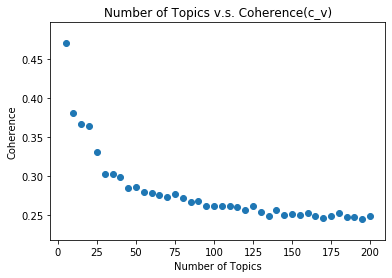

In [330]:
# First try to find optimal number of topics
num_topics = [i for i in range(5,201,5)]
coherence_values,model_list = topicsSelection(X_train,X_train_tfidf,num_topics,dictionary)

plt.scatter(num_topics, coherence_values)
plt.title('Number of Topics v.s. Coherence(c_v)')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')

As above graph shown, coherence score drops as the number of topics increases from 5 to 200. Next, we will use grid search for number of topics from 1 to 9.

Text(0, 0.5, 'Coherence')

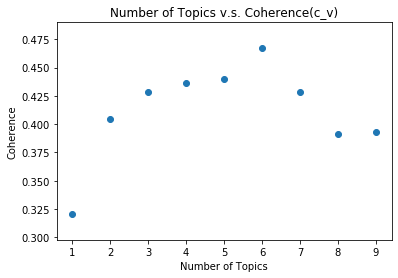

In [392]:
# Second try to find optimal number of topics
num_topics1 = [i for i in range(1,10)]
coherence_values1,model_list1 = topicsSelection(X_train,X_train_tfidf,num_topics1,dictionary)
plt.scatter(num_topics1, coherence_values1)
plt.title('Number of Topics v.s. Coherence(c_v)')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')

In [426]:
print('When we have 6 topics, the coherence is:',round(coherence_values1[5],3))

When we have 6 topics, the coherence is: 0.467


From above results, the coherence score reaches the peak when we have 6 topics. So, we select the model with 6 topics as our final model. 

## Measure the performance of LSI for books recommendation system

Here, we will build a book recommendation system which would recommend top 10 similar books based on plots description in wikipedia. To measure the performance of our system, we split each sample in the testing set into two parts. Our goal is to see whether we could use the data from first half to find the second half of same book. So, we now transform it into a classification problem and could measure the performance by accuracy.

Specifically, one part is the input to find 10 similar books, another part would be put into the book pool. Then, we apply the selected LSI model to transform the two parts of the testing set. The system would calcuate the cosine similarity between each book in the pool and the input book, and then output the top 10 similar books. We'll use cosine similarity to measure distance between books. 

In [538]:
# split testing set into two parts
X_test_first = [doc[:len(doc)//2] for doc in X_test]
X_test_second = [doc[len(doc)//2:] for doc in X_test]
y_test_first = [title for title in y_test]
y_test_second = [title+' Second' for title in y_test]

# select a lsi model
lsi = model_list1[5]

In [531]:
# apply LSI model to represent documents by topics
X_pool_lsi = []
for doc in X_train:
    topics = [topic[1] for topic in lsi[dictionary.doc2bow(doc)]]
    X_train_lsi.append(topics)

X_test_first_lsi = []
for doc in X_test_first:
    topics = [topic[1] for topic in lsi[dictionary.doc2bow(doc)]]
    X_test_first_lsi.append(topics)

X_test_second_lsi = []
for doc in X_test_second:
    topics = [topic[1] for topic in lsi[dictionary.doc2bow(doc)]]
    X_test_second_lsi.append(topics)

# Build a book pool for recommendation system
X_pool_lsi.extend(X_test_second_lsi)
y_pool_lsi = list(y_train) + list(y_test_second)

In [532]:
y_pool_lsi[-2]
len(X_pool_lsi)

'Concept of the Corporation Second'

In [483]:
# output the topics matrix of X for visualization
X_lsi = []
for doc in X:
    topics = [topic[1] for topic in lsi[dictionary.doc2bow(doc)]]
    X_lsi.append(topics)

df1 = pd.DataFrame(X_lsi)
df1['Title'] = list(df['Title'])
df1.to_csv('X_lsi.csv')

In [545]:
# build up a recoomendation sytem
class recommendSystem:
    
    def __init__(self,X_pool,y_pool,book_list,n):
        self.X_pool = X_pool
        self.y_pool = y_pool
        self.book_list = book_list
        self.n = n
    
    def similarity(self,book):
        return list(cosine_similarity(self.X_pool,book))
    
    def findLargest(self,sim_mat):
        idx = []
        val = []
        while len(idx) < self.n:
            largest = -float('inf')
            largest_idx = -1
            for i in range(len(sim_mat)):
                if sim_mat[i] > largest and i not in idx:
                    largest = sim_mat[i]
                    largest_idx = i
            idx.append(largest_idx)
            val.append(largest)
        return idx, val
    
    def recommender(self):
        book_recommend = []
        for b in self.book_list:
            sim_mat = self.similarity(np.array(b).reshape(-1,len(b)))
            idx,_ = self.findLargest(sim_mat)
            recommed = [self.y_pool[i] for i in idx]
            book_recommend.append(recommed)
        return book_recommend
    

In [548]:
book_list = X_test_first_lsi[:100]
n = 100
recom= recommendSystem(X_pool_lsi,y_pool_lsi,book_list,n)

In [549]:
book_recommend = recom.recommender()

In [552]:
fp = 0
for i in range(len(book_list)):
    if y_test_first[i]+' Second' in book_recommend[i]:
        fp += 1
